<a href="https://colab.research.google.com/github/christian-santibanez/Colab/blob/main/IA_sentimiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


betsentiment_es.zip 100%[===================>]  19.48M  --.-KB/s    in 0.1s    
replace betsentiment_es/betsentiment-ES-tweets-sentiment-teams.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archivos descargados:
- betsentiment-ES-tweets-sentiment-teams.csv
Accuracy: 0.7966160823303681
              precision    recall  f1-score   support

    negativo       0.79      0.84      0.81      1911
     neutral       0.78      0.75      0.76      1911
    positivo       0.82      0.80      0.81      1911

    accuracy                           0.80      5733
   macro avg       0.80      0.80      0.80      5733
weighted avg       0.80      0.80      0.80      5733


Escribe un comentario (o 'salir'):Me aburrí mucho
→ Sentimiento: positivo

Escribe un comentario (o 'salir'):Me aburrí demaciado
→ Sentimiento: positivo

Escribe un comentario (o 'salir'):Me aburrí demasiado
→ Sentimiento: negativo

Escribe un comentario (o 'salir'):estuvo fome
→ Sentimiento: neutral

Escribe un comentario (o 'salir

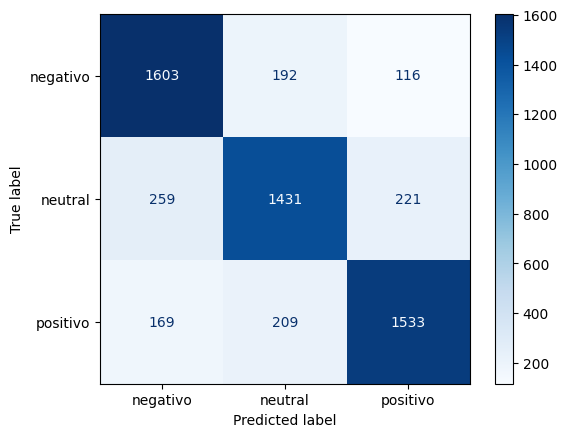

In [ ]:
# ===========================================
#   PROYECTO: CLASIFICADOR DE SENTIMIENTO
#   MODELO: TF-IDF + Regresión logística
#   DATOS: Dataset propio + dataset público (GitHub)
# ===========================================

# Importaciones generales
import os
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import joblib

# ===========================================
#   1. Cargar dataset público desde GitHub
# ===========================================

!wget -q --show-progress "https://github.com/charlesmalafosse/open-dataset-for-sentiment-analysis/raw/master/betsentiment-ES-tweets-sentiment-teams.zip" -O betsentiment_es.zip
!unzip -q betsentiment_es.zip -d betsentiment_es

print("Archivos descargados:")
for f in os.listdir("betsentiment_es"):
    print("-", f)

csv_path = "betsentiment_es/betsentiment-ES-tweets-sentiment-teams.csv"

df_public = pd.read_csv(csv_path, encoding="latin1", on_bad_lines="skip")

# ===========================================
#   2. Cargar dataset propio (Excel)
# ===========================================
df_own = pd.read_excel("Detección de sentimientos.xlsx")

# ===========================================
#   3. Homogeneizar columnas
# ===========================================

df_public = df_public.rename(columns={"tweet_text": "text", "sentiment": "label"})
df_own = df_own.rename(columns={"Texto": "text", "Sentimiento": "label"})

# ===========================================
#   4. Normalizar etiquetas a: positivo/neutral/negativo
# ===========================================

def map_label(x):
    x = str(x).lower()
    if "pos" in x: return "positivo"
    if "neg" in x: return "negativo"
    if "neu" in x: return "neutral"
    if "mix" in x: return "neutral"
    return x

df_public["label"] = df_public["label"].apply(map_label)
df_own["label"] = df_own["label"].apply(map_label)

# ===========================================
#   5. Unir ambos datasets
# ===========================================
df_public["source"] = "public"
df_own["source"] = "own"
df_all = pd.concat([df_public, df_own], ignore_index=True)

# ===========================================
#   6. Limpiar texto
# ===========================================
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"http\S+", "", s)
    s = re.sub(r"@\w+", "", s)
    s = re.sub(r"#", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df_all["text_clean"] = df_all["text"].apply(clean_text)

# ===========================================
#   7. Balancear dataset
# ===========================================

from sklearn.utils import resample

df_pos = df_all[df_all["label"] == "positivo"]
df_neg = df_all[df_all["label"] == "negativo"]
df_neu = df_all[df_all["label"] == "neutral"]

min_size = min(len(df_pos), len(df_neg), len(df_neu))

df_bal = pd.concat([
    df_pos.sample(min_size, random_state=42),
    df_neg.sample(min_size, random_state=42),
    df_neu.sample(min_size, random_state=42),
], ignore_index=True)

# ===========================================
#   8. Entrenar modelo
# ===========================================
train_df, test_df = train_test_split(df_bal, test_size=0.2, random_state=42, stratify=df_bal["label"])

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=20000)),
    ("clf", LogisticRegression(max_iter=1000))
])

pipeline.fit(train_df["text_clean"], train_df["label"])

# ===========================================
#   9. Métricas
# ===========================================
y_pred = pipeline.predict(test_df["text_clean"])
print("Accuracy:", accuracy_score(test_df["label"], y_pred))
print(classification_report(test_df["label"], y_pred))

cm = confusion_matrix(test_df["label"], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="Blues")

# ===========================================
#   10. Entrada por consola
# ===========================================
def predict_sentiment(text):
    text_cleaned = clean_text(text)
    return pipeline.predict([text_cleaned])[0]

while True:
    user = input("\nEscribe un comentario (o 'salir'):")
    if user.lower() == "salir":
        break
    print("→ Sentimiento:", predict_sentiment(user))
